In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import scipy

In [2]:
style.use('ggplot')

In [3]:
NRUNS = 1

## Get parameters from calibration

In [4]:
pickle_in = open("nm_calibration_result.pickle","rb")
calibration_result = pickle.load(pickle_in)
print(calibration_result[0]['xopt'])
print(['trader_sample_size', 'std_noise', 'w_fundamentalists', 'w_momentum',
                      'init_stocks', 'base_risk_aversion', 'horizon'])

UnicodeDecodeError: 'ascii' codec can't decode byte 0x94 in position 0: ordinal not in range(128)

In [5]:
# convert relevant parameters to integers
integer_var_locations = [0, 4, 6]
new_input_params = []
for idx, par in enumerate(calibration_result[0]['xopt']):
    if idx in integer_var_locations:
        new_input_params.append(int(par))
    else:
        new_input_params.append(par.item())

In [6]:
uncertain_parameters = dict(zip(['trader_sample_size', 'std_noise', 'w_fundamentalists', 'w_momentum',
                      'init_stocks', 'base_risk_aversion', 'horizon'], new_input_params))
params = {"ticks": 10235, "fundamental_value": 166, 'n_traders': 1000, 'std_fundamental': 0.0530163128919286,
              'spread_max': 0.004087, "w_random": 1.0}
params.update(uncertain_parameters)
params

{'base_risk_aversion': 13.04209230587413,
 'fundamental_value': 166,
 'horizon': 26,
 'init_stocks': 17,
 'n_traders': 1000,
 'spread_max': 0.004087,
 'std_fundamental': 0.0530163128919286,
 'std_noise': 0.20813277184315787,
 'ticks': 10235,
 'trader_sample_size': 26,
 'w_fundamentalists': 47.61067793142201,
 'w_momentum': 55.01524438775738,
 'w_random': 1.0}

In [4]:
params = {'base_risk_aversion': 13.04209230587413,
 'fundamental_value': 166,
 'horizon': 26,
 'init_stocks': 17,
 'n_traders': 1000,
 'spread_max': 0.004087,
 'std_fundamental': 0.0530163128919286,
 'std_noise': 0.20813277184315787,
 'ticks': 10235,
 'trader_sample_size': 26,
 'w_fundamentalists': 47.61067793142201,
 'w_momentum': 55.01524438775738,
 'w_random': 1.0}

In [5]:
params['w_fundamentalists'] = 11.0
params

{'base_risk_aversion': 13.04209230587413,
 'fundamental_value': 166,
 'horizon': 26,
 'init_stocks': 17,
 'n_traders': 1000,
 'spread_max': 0.004087,
 'std_fundamental': 0.0530163128919286,
 'std_noise': 0.20813277184315787,
 'ticks': 10235,
 'trader_sample_size': 26,
 'w_fundamentalists': 11.0,
 'w_momentum': 55.01524438775738,
 'w_random': 1.0}

## Run model

In [6]:
trdrs = []
obs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    obs.append(orderbook)

Start of simulation  0


# Analyse dynamics

In [7]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs, burn_in_period=0)

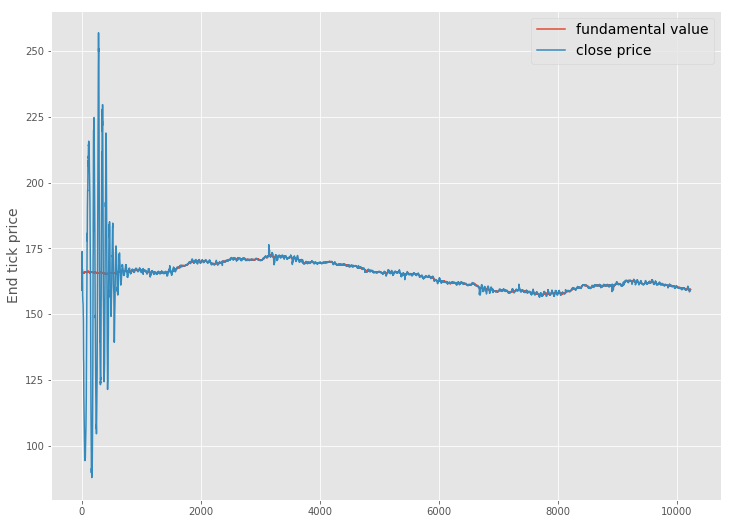

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals[0], label='fundamental value')
ax1.plot(mc_prices.index, mc_prices[0], label='close price')

ax1.set_ylabel('End tick price', fontsize='14')
ax1.legend(loc='best', fontsize='14')

#fig.savefig('behavioural_hypothesis.png')

## Distributional dynamics

I am interested in the following distributions:

* wealth
* stocks
* money

I am interested in the following properties of the wealth distribution

1. Gini coefficient & Lorenz curve
2. Skew? 
3. Kurtosis? 
4. Concentration curves? 

### Money

In [9]:
# at the end of the simulation
money_holdings = np.array([x.var.money[-1] for x in trdrs[0]])

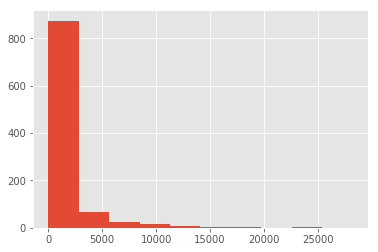

In [10]:
pd.Series(np.sort(money_holdings)).hist()

In [11]:
gini(money_holdings)

0.7260044433503521

Gini Evolution over time

In [12]:
money_gini_over_time = []
for t in range(params['ticks']):
    #print(t)
    money = np.array([x.var.money[t] for x in trdrs[0]])
    money_gini_over_time.append(gini(money))

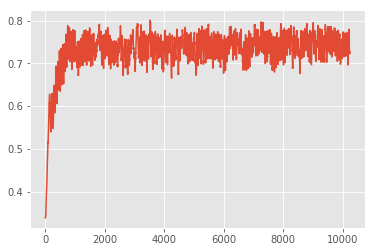

In [13]:
pd.Series(money_gini_over_time).plot()

### The distribution of Wealth
Wealth is measured as trader money + trader stock * price 

In [14]:
money = np.array([x.var.money[-1] for x in trdrs[0]])
stocks = np.array([x.var.stocks[-1] for x in trdrs[0]])
wealth = money + (stocks * mc_prices[0].iloc[-1])
#n, bins, patches = plt.hist(wealth, 50, density=True, alpha=0.75)

In [26]:
start_money = np.array([x.var.money[0] for x in trdrs[0]])
start_stocks = np.array([x.var.stocks[0] for x in trdrs[0]])
start_wealth = start_money + (start_stocks * mc_prices[0].iloc[0])

### Descriptives

In [15]:
pd.Series(wealth).describe()

count     1000.000000
mean      2657.952317
std       3656.829781
min         40.217776
25%        700.840446
50%       1297.379736
75%       2824.967179
max      28219.931093
dtype: float64

Skewness and Kurtosis

In [16]:
print('Skewness is ', pd.Series(wealth).skew())
print('Kurtosis is ', pd.Series(wealth).kurtosis())

Skewness is  3.0708604617479347
Kurtosis is  11.605349093078058


### Ratios

#### Palma ratio
It is the ratio of national income shares of the top 10 per cent of
households to the bottom 40 per cent.

In [17]:
share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
print('Share top 10 is ', share_top_10)
share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
print('Share bottom 40 is ', share_bottom_40)

Share top 10 is  0.44534939073186036
Share bottom 40 is  0.09141021404355809


In [18]:
palma = share_top_10 / share_bottom_40
print('Palma ratio is ', palma)

Palma ratio is  4.871987177709111


### 20/20 ratio
Compares the ratio of the average income of the richest 20
per cent of the population to the average income of the poorest
20 per cent of the population.

In [19]:
share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
print('Average wealth top 20 is ', share_top_20)
share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
print('Average wealth bottom 20 is ', share_bottom_20)
twenty_twenty = share_top_20 / share_bottom_20
print('20/20 ratio is ', twenty_twenty)

Average wealth top 20 is  8390.238819999386
Average wealth bottom 20 is  417.046313437049
20/20 ratio is  20.118242386204066


### Cumulative distribution

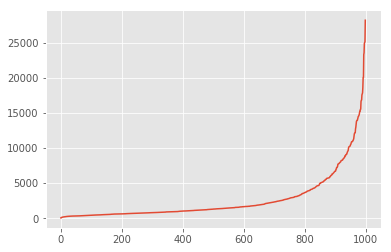

In [20]:
pd.Series(np.sort(wealth)).plot()

## Lorenz curve and Gini coefficient 

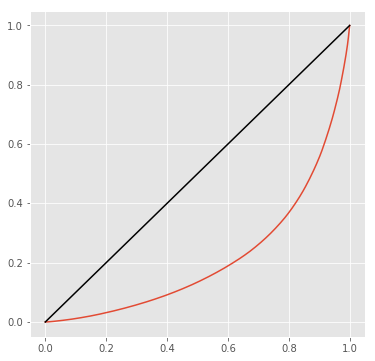

In [21]:
lorenz_curve(np.sort(wealth))

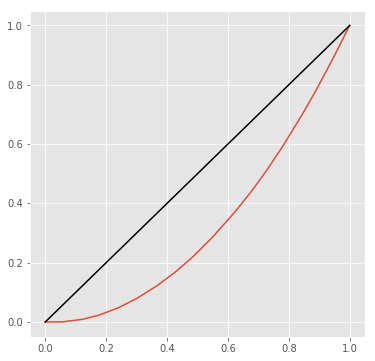

In [29]:
lorenz_curve(np.sort(start_stocks))

In [30]:
wealth_gini_over_time = []
palma_over_time = []
twentytwenty_over_time = []
for t in range(params['ticks']):
    #print(t)
    money = np.array([x.var.money[t] for x in trdrs[0]])
    stocks = np.array([x.var.stocks[t] for x in trdrs[0]])
    wealth = money + (stocks * obs[0].tick_close_price[t])
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palma_over_time.append(share_top_10 / share_bottom_40)
    
    share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
    share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
    twentytwenty_over_time.append(share_top_20 / share_bottom_20)
    
    wealth_gini_over_time.append(gini(wealth))

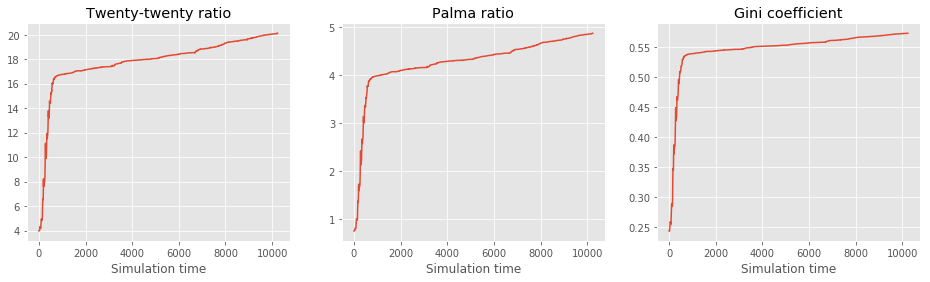

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

ax1.plot(range(len(twentytwenty_over_time)), twentytwenty_over_time)
ax2.plot(range(len(palma_over_time)), palma_over_time)
ax3.plot(range(len(wealth_gini_over_time)), wealth_gini_over_time)

ax1.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax3.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation time')

fig.savefig('gini_palma_twenty_evolution.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Correlation coefficient